## Análise de dados da rede Hidro da ANA

Sumário

1. Base de dados da rede Hidro ANA
1. Espacialização da Rede Hidrometereologica Nacional

...

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import seaborn as sns
import datetime

### 1. Base de dados da rede Hidro ANA

Dados importados em importHidro.ipynb do inventario do Hidro ANA, segundo o documento "DESCRIÇÃO PARA DISPONIBILIZAR DADOS HIDROMETEOROLÓGICOS DOS SISTEMAS TELEMETRIA 1 E HIDRO" da ANA, disponível em https://www.ana.gov.br/telemetria1ws/Telemetria1ws.pdf

- data de atualização: 01/1/2020

In [39]:
### importa os dados das estações pelo arquivo .csv
dfHidro = pd.read_csv('dfHidro.csv', sep=',', encoding='UTF-8')
dfHidro.head()

Unnamed: 0  BaciaCodigo  SubBaciaCodigo  RioCodigo nmEstado  nmMunicipio  \
0           1            3              32        NaN     PARÁ  SALINÓPOLIS   
1           2            3              32        NaN     PARÁ     MARACANÃ   
2           3            3              32        NaN     PARÁ  SALINÓPOLIS   
3           4            3              32        NaN     PARÁ       CURUÇA   
4           5            3              32        NaN     PARÁ    PRIMAVERA   

  ResponsavelSigla OperadoraSigla  TipoEstacao  Codigo  ...  \
0            INMET          INMET            2   47000  ...   
1            IDESP          IDESP            2   47001  ...   
2              ANA           CPRM            2   47002  ...   
3              ANA           CPRM            2   47003  ...   
4              ANA           CPRM            2   47004  ...   

  TipoRedeEnergetica  TipoRedeNavegacao  TipoRedeCursoDagua  \
0                0.0                0.0                 0.0   
1                0.0                0.0                 9.0   
2                0.0                0.0                 0.0   
3                0.0                0.0                 0.0   
4                0.0                0.0                 0.0   

   TipoRedeEstrategica  TipoRedeCaptacao  TipoRedeSedimentos  \
0                  0.0               1.0                 0.0   
1                  0.0               3.0                 0.0   
2                  0.0               7.0                 0.0   
3                  0.0               7.0                 0.0   
4                  0.0               7.0                 0.0   

   TipoRedeQualAgua  TipoRedeClasseVazao  UltimaAtualizacao  Operando  
0               0.0                  0.0         2019-03-21         0  
1               0.0                  0.0         2005-03-29         1  
2               0.0                  0.0         2018-06-18         1  
3               0.0                  0.0         2018-06-18         1  
4               0.0                  0.0         2018-02-07         1  

[5 rows x 59 columns]

In [41]:
dfHidro['TipoRedeEstrategica'].value_counts()

0.0    39890
1.0      541
Name: TipoRedeEstrategica, dtype: int64

In [4]:
### lista os nomes das colunas para verificação do data frame
dfHidro.columns.values

array(['Unnamed: 0', 'BaciaCodigo', 'SubBaciaCodigo', 'RioCodigo',
       'nmEstado', 'nmMunicipio', 'ResponsavelSigla', 'OperadoraSigla',
       'TipoEstacao', 'Codigo', 'Nome', 'Latitude', 'Longitude',
       'Altitude', 'AreaDrenagem', 'TipoEstacaoEscala',
       'TipoEstacaoRegistradorNivel', 'TipoEstacaoDescLiquida',
       'TipoEstacaoSedimentos', 'TipoEstacaoQualAgua',
       'TipoEstacaoPluviometro', 'TipoEstacaoRegistradorChuva',
       'TipoEstacaoTanqueEvapo', 'TipoEstacaoClimatologica',
       'TipoEstacaoPiezometria', 'TipoEstacaoTelemetrica',
       'PeriodoEscalaInicio', 'PeriodoEscalaFim',
       'PeriodoRegistradorNivelInicio', 'PeriodoRegistradorNivelFim',
       'PeriodoDescLiquidaInicio', 'PeriodoDescLiquidaFim',
       'PeriodoSedimentosInicio', 'PeriodoSedimentosFim',
       'PeriodoQualAguaInicio', 'PeriodoQualAguaFim',
       'PeriodoPluviometroInicio', 'PeriodoPluviometroFim',
       'PeriodoRegistradorChuvaInicio', 'PeriodoRegistradorChuvaFim',
       'Periodo

In [5]:
### função para mapear uma coluna com um dicionário externo em arquivo .csv
def ImportName(DataColumn, Filename, Column):
    df = pd.read_csv(Filename, sep=',', encoding='UTF-8')
    Dict = dict(zip(df['Codigo'], df[Column]))
    DataName = DataColumn.map(Dict)
    return DataName

In [6]:
### insere colunas no data frame com os nomes das [Bacia], [SubBacia] e [Rio] substituindo os códigos
dfHidro['Bacia'] = ImportName(dfHidro['BaciaCodigo'], 'Bacia.csv', 'Nome')
dfHidro['SubBacia'] = ImportName(dfHidro['SubBaciaCodigo'], 'SubBacia.csv', 'Nome')
dfHidro['Rio'] = ImportName(dfHidro['RioCodigo'], 'Rio.csv', 'Nome')
# dfHidro.head()

In [7]:
### insere colunas no data frame com a descrição do [TipoEstacao] substituindo os códigos 1 e 2
dfHidro['TipoEstacao'] = dfHidro['TipoEstacao'].map({1: 'Fluviometrica', 2: 'Pluviometrica'})
dfHidro['TipoEstacao'].value_counts()
# dfHidro.head()

Pluviometrica    22717
Fluviometrica    17781
Name: TipoEstacao, dtype: int64

- Os passos a seguir vao analisar a quantidade de estações que estão em operação (1) e fora de operação (0) e selecionar apenas as que estão em operação, caso queira manter todas as estacoes basta desabilitar o comando.

In [8]:
### número de estações em operação e fora de operação
dfHidro['Operando'].value_counts()

1    26511
0    13987
Name: Operando, dtype: int64

In [9]:
DataInicio = ['PeriodoEscalaInicio', 'PeriodoRegistradorNivelInicio', 'PeriodoDescLiquidaInicio',
              'PeriodoSedimentosInicio', 'PeriodoQualAguaInicio', 'PeriodoPluviometroInicio',
              'PeriodoRegistradorChuvaInicio', 'PeriodoTanqueEvapoInicio',
              'PeriodoClimatologicaInicio', 'PeriodoPiezometriaInicio', 'PeriodoTelemetricaInicio']

DataFim = ['PeriodoEscalaFim', 'PeriodoRegistradorNivelFim', 'PeriodoDescLiquidaFim',
           'PeriodoSedimentosFim', 'PeriodoQualAguaFim', 'PeriodoPluviometroFim',
           'PeriodoRegistradorChuvaFim', 'PeriodoTanqueEvapoFim', 'PeriodoClimatologicaFim',
           'PeriodoPiezometriaFim', 'PeriodoTelemetricaFim']

In [10]:
pd.to_datetime(dfHidro['PeriodoPluviometroInicio'][1]).year

1972

In [11]:
for _date in DataInicio:
    a = getattr(dfHidro.loc[1], _date, None)

In [12]:
### ao selecionar este comando, passamos a avaliar somente as estações que estão com status operando = 1
### observar que os números de estações no data frame irá reduzir para a quantidade de estações operando = 1
# dfHidroT = dfHidro
dfHidro = dfHidro[dfHidro.Operando == 1]

- Criamos os data frames separados por tipo de estações Pluviométricas e Fluviométricas para facilitar as análises.

In [13]:
### cria os data frames df_RHN_flu e df_RHN_plu
dfHidroFlu = dfHidro[dfHidro['TipoEstacao'] == 'Fluviometrica']
dfHidroPlu = dfHidro[dfHidro['TipoEstacao'] == 'Pluviometrica']

### 2. Espacialização da Rede Hidrometereológica Nacional

2.1. Mapa de densidade hexabin por tipo
* Função para plotar os mapas de distribuição - scatter
* Função para plotar os mapas de densidade hexabin
* Mapas com todas as estações pluviométricas e fluviométricas da rede Hidro
* Mapa de densidade hexabin com todas as estações
* Mapas de densidade hexabin por tipo de estação
* Mapas de densidade hexabin por tipo de rede

In [14]:
### função para plotar o mapa de distribuição - scatter
#       Data:  'Data frame contendo a base de dados',
#       Type:  'Tipo da rede ou tipo da estação (ver as colunas do data frame)',
#       Title: 'Título do Mapa',
#       Color: 'Cor')
### -----
def ScatterMap(Data, Type, Title, Color):
    ### formato do mapa
    fig = plt.figure(figsize = (10,8))
    ax = fig.add_subplot(1,1,1, projection = ccrs.PlateCarree())
    ax.set_extent([-100,-20,-60,15], crs = ccrs.PlateCarree())
    ax.set_title(Title)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle = ':')
    gl = ax.gridlines(draw_labels = True, linewidth = 0)
    gl.right_labels = False
    gl.top_labels = False
    ### plot scatter
    if Type == '':
        Data.plot.scatter(ax = ax, x = 'Longitude', y = 'Latitude', s = 0.5, c = Color)
    else:
        Data[Data[Type] == 1].plot.scatter(ax = ax, x = 'Longitude', y = 'Latitude', s = 0.5, c = Color)
    plt.show()

In [15]:
### função para plotar o mapa de densidade hexbin
#       Data:  'Data frame contendo a base de dados',
#       Type:  'Tipo da rede ou tipo da estação (ver as colunas do data frame)',
#       Title: 'Título do Mapa',
#       Color: 'Cores de acordo com a paleta de cores do matplotlib')
### -----
def HexbinDensityMap(Data, Type, Title, Color):
    ### formato do mapa
    fig = plt.figure(figsize = (10,8))
    ax = fig.add_subplot(1,1,1, projection = ccrs.PlateCarree())
    ax.set_extent([-100,-20,-60,15], crs = ccrs.PlateCarree())
    ax.set_title(Title)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle = ':')
    gl = ax.gridlines(draw_labels = True, linewidth = 0)
    gl.right_labels = False
    gl.top_labels = False
    ### plot hexabin
    if Type == '':
        Data.plot.hexbin(ax = ax, x = 'Longitude', y = 'Latitude', reduce_C_function = np.sum, gridsize = 25, cmap = Color)
    else:
        Data[Data[Type] == 1].plot.hexbin(ax = ax, x = 'Longitude', y = 'Latitude', C = Type, reduce_C_function = np.sum, gridsize = 25, cmap = Color)
    plt.show()

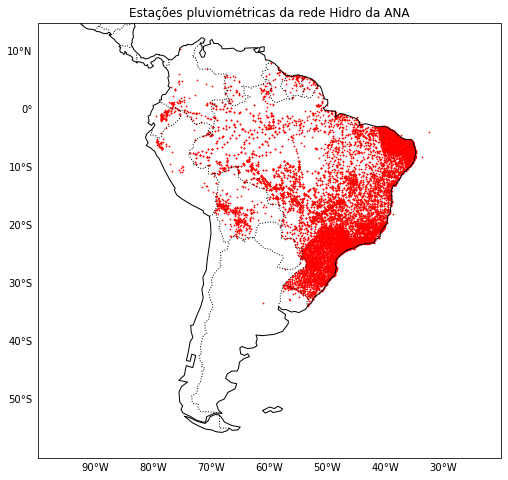

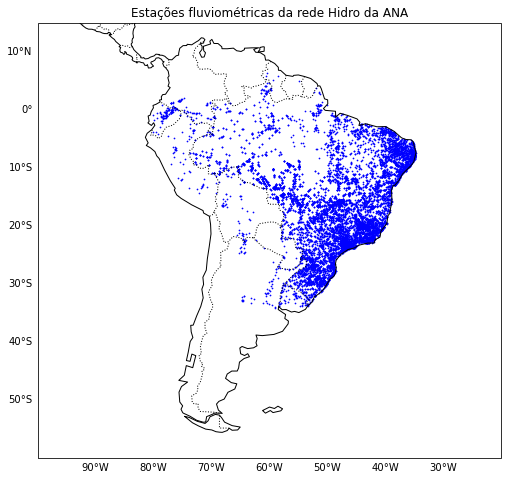

In [16]:
### mapas de densidade hexabin de todas as estações
### função ScatterMap(Data, Type, Title, Color)
ScatterMap(dfHidroPlu, '', 'Estações pluviométricas da rede Hidro da ANA', 'red')
ScatterMap(dfHidroFlu, '', 'Estações fluviométricas da rede Hidro da ANA', 'blue')

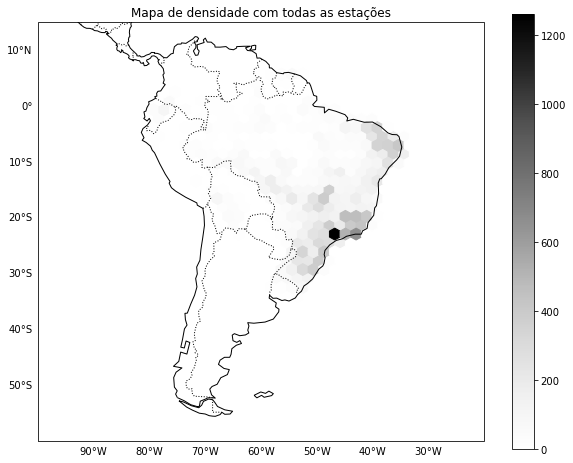

In [17]:
### mapas de densidade hexabin de todas as estações
### função HexbinDensityMap(Data, Type, Title, Color)
HexbinDensityMap(dfHidro, '', 'Mapa de densidade com todas as estações', 'Greys')

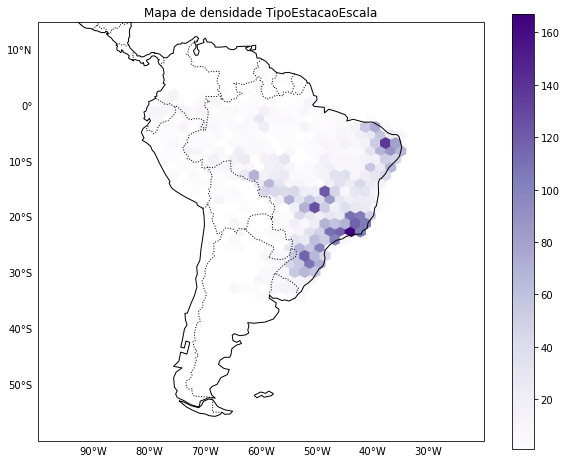

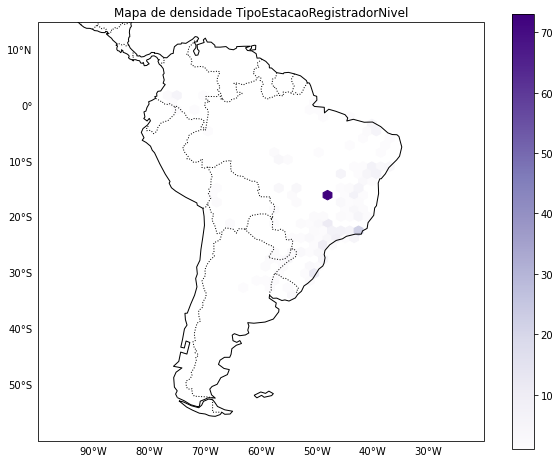

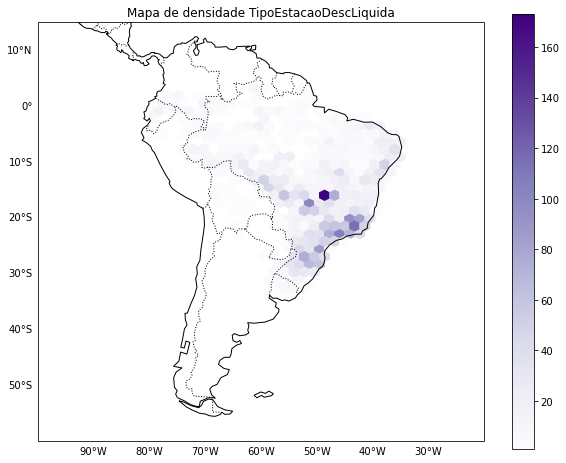

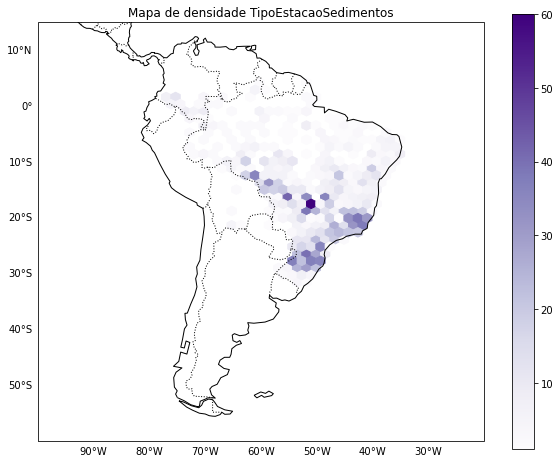

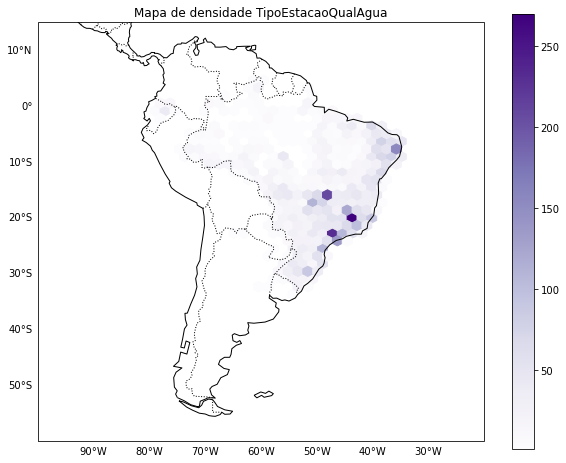

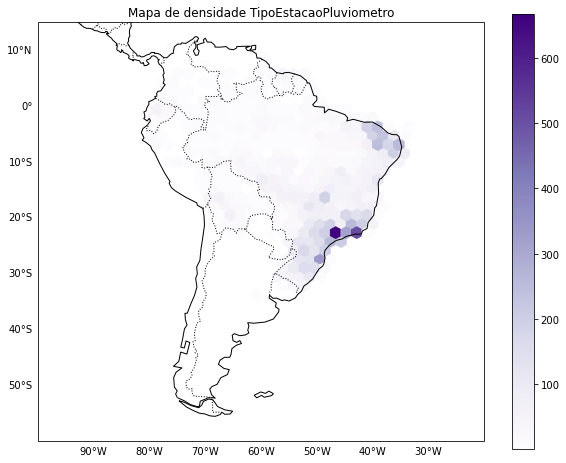

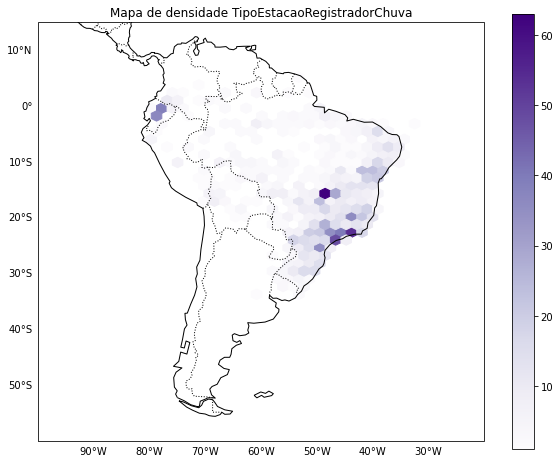

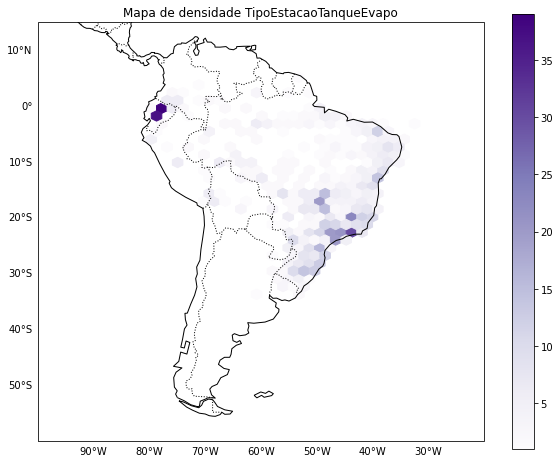

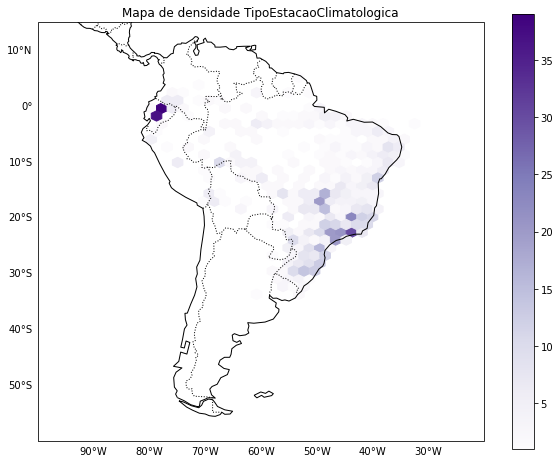

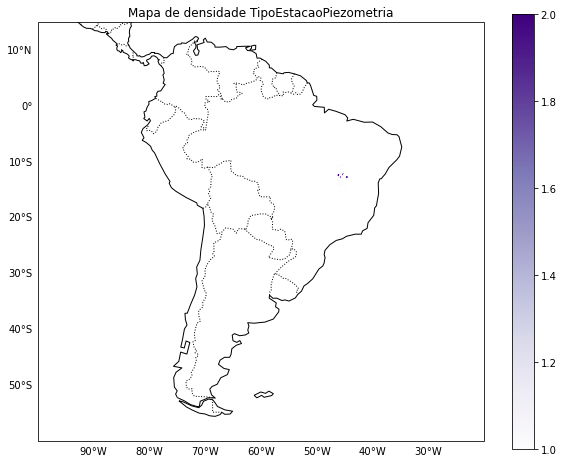

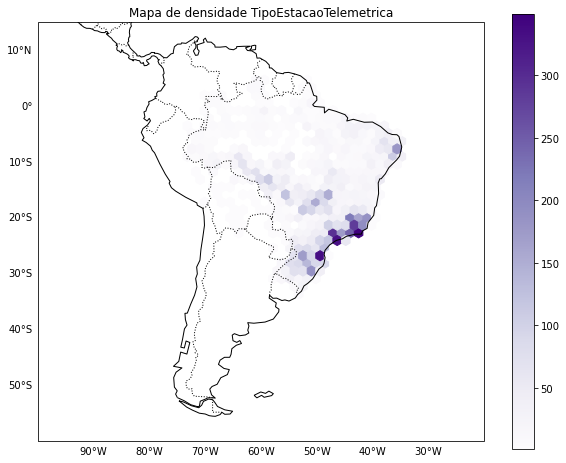

In [18]:
### mapas de densidade hexabin por tipo de estação
TipoEstacao = ['TipoEstacaoEscala', 'TipoEstacaoRegistradorNivel', 'TipoEstacaoDescLiquida',
               'TipoEstacaoSedimentos', 'TipoEstacaoQualAgua', 'TipoEstacaoPluviometro',
               'TipoEstacaoRegistradorChuva', 'TipoEstacaoTanqueEvapo', 'TipoEstacaoClimatologica',
               'TipoEstacaoPiezometria', 'TipoEstacaoTelemetrica']
for aux in TipoEstacao:
    ### função HexbinDensityMap(Data, Type, Title, Color)
    HexbinDensityMap(dfHidro, aux, 'Mapa de densidade {}'.format(aux), 'Purples')

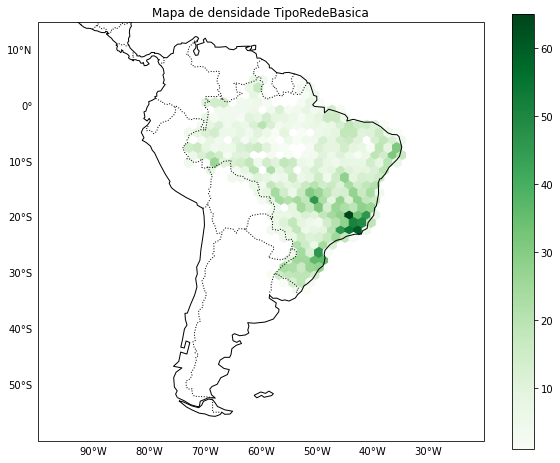

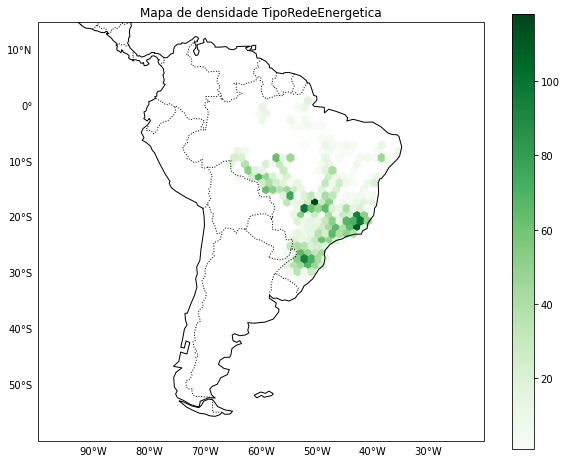

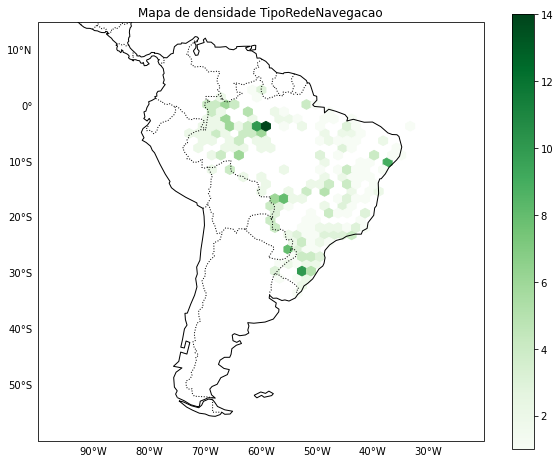

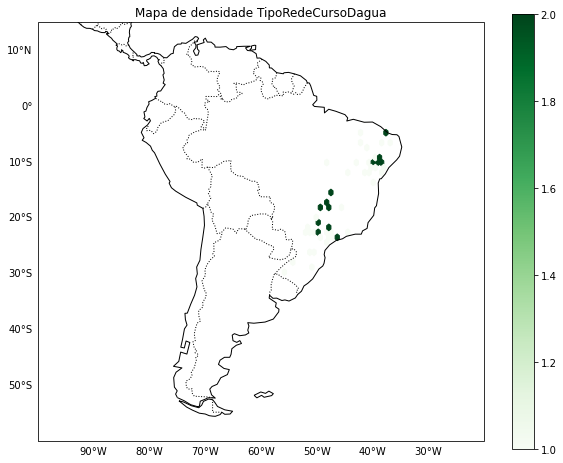

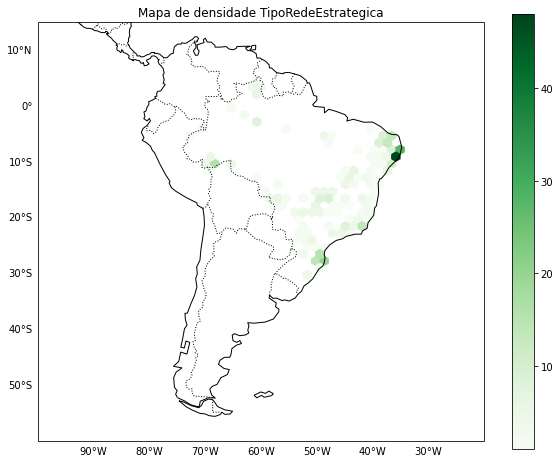

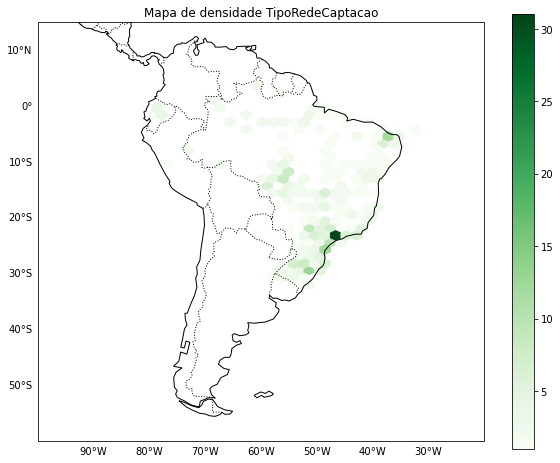

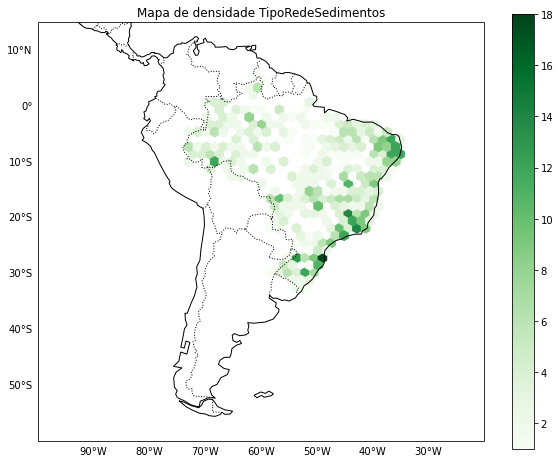

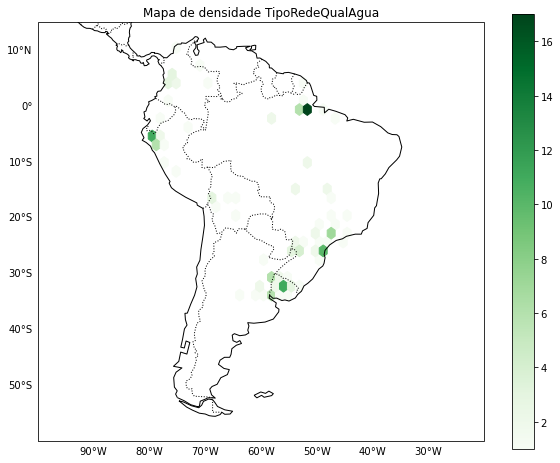

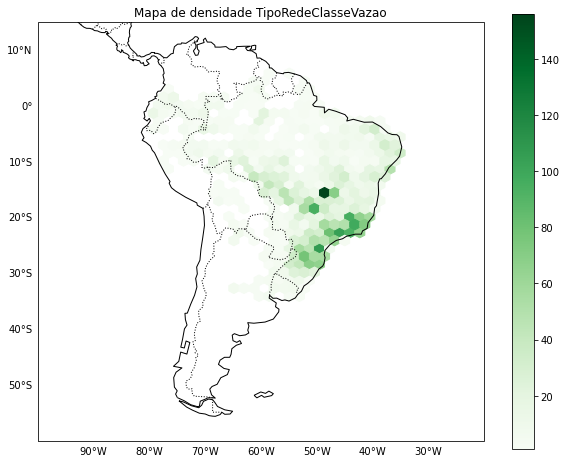

In [19]:
### mapas de densidade hexabin por tipo de rede
TipoRede = ['TipoRedeBasica', 'TipoRedeEnergetica', 'TipoRedeNavegacao',
            'TipoRedeCursoDagua', 'TipoRedeEstrategica', 'TipoRedeCaptacao',
            'TipoRedeSedimentos', 'TipoRedeQualAgua', 'TipoRedeClasseVazao',]
for aux in TipoRede:
    ### função HexbinDensityMap(Data, Type, Title, Color)
    HexbinDensityMap(dfHidro, aux, 'Mapa de densidade {}'.format(aux), 'Greens')

## Operadoras e responsáveis pelas estações

In [20]:
dfHidro['ResponsavelSigla'].value_counts().head(15)

ANA           5589
CEMADEN       2611
DAEE-SP       1356
IGAM-MG        780
FUNCEME-CE     769
INEMA-BA       690
IAT-PR         654
CETESB-SP      589
DNOCS          575
INMET          566
BOLÍVIA        430
AESA-PB        371
SEMA-RS        329
SEMA-MT        320
INEA-RJ        309
Name: ResponsavelSigla, dtype: int64

In [24]:
dfHidro['OperadoraSigla'].value_counts().head(15)

CPRM          4396
CEMADEN       2611
DAEE-SP       1360
IGAM-MG        937
IAT-PR         848
INEMA-BA       814
FUNCEME-CE     771
CETESB-SP      589
DNOCS          572
INMET          566
AESA-PB        487
BOLÍVIA        430
CONSTRUFAM     315
SEMAD-GO       260
SEMA-RS        254
Name: OperadoraSigla, dtype: int64

In [43]:
dfRHNR = dfHidro[(dfHidro['TipoRedeEstrategica'] == 1) & (dfHidro['ResponsavelSigla'] == 'ANA')]

In [44]:
dfRHNR[(dfRHNR['OperadoraSigla'] == 'CONSTRUFAM') & (dfRHNR['nmEstado'] == 'SÃO PAULO')]

Unnamed: 0  BaciaCodigo  SubBaciaCodigo   RioCodigo   nmEstado  \
34752       34753            6              61  61500000.0  SÃO PAULO   
34825       34826            6              61  61550000.0  SÃO PAULO   
34895       34896            6              61  61550000.0  SÃO PAULO   
35482       35483            6              62  62263000.0  SÃO PAULO   
35492       35493            6              62  62263000.0  SÃO PAULO   
35571       35572            6              62  62260100.0  SÃO PAULO   

             nmMunicipio ResponsavelSigla OperadoraSigla  TipoEstacao  \
34752     RIBEIRÃO PRETO              ANA     CONSTRUFAM            1   
34825            CONCHAL              ANA     CONSTRUFAM            1   
34895          GUATAPARÁ              ANA     CONSTRUFAM            1   
35482  BRAGANÇA PAULISTA              ANA     CONSTRUFAM            1   
35492         JAGUARIUNA              ANA     CONSTRUFAM            1   
35571            ATIBAIA              ANA     CONSTRUFAM            1   

         Codigo  ... TipoRedeEnergetica  TipoRedeNavegacao  \
34752  61834000  ...                0.0                0.0   
34825  61886000  ...                0.0                0.0   
34895  61912000  ...                0.0                0.0   
35482  62600000  ...                0.0                0.0   
35492  62615000  ...                0.0                0.0   
35571  62670000  ...                0.0                0.0   

       TipoRedeCursoDagua  TipoRedeEstrategica  TipoRedeCaptacao  \
34752                 3.0                  1.0               7.0   
34825                 2.0                  1.0               7.0   
34895                 2.0                  1.0               7.0   
35482                 2.0                  1.0               7.0   
35492                 2.0                  1.0               7.0   
35571                 2.0                  1.0               7.0   

       TipoRedeSedimentos  TipoRedeQualAgua  TipoRedeClasseVazao  \
34752                 1.0               3.0                  1.0   
34825                 0.0               3.0                  1.0   
34895                 1.0               3.0                  1.0   
35482                 1.0               3.0                  1.0   
35492                 1.0               3.0                  1.0   
35571                 1.0               3.0                  1.0   

       UltimaAtualizacao  Operando  
34752         2018-12-12         1  
34825         2018-12-10         1  
34895         2018-10-30         1  
35482         2019-12-12         1  
35492         2019-12-12         1  
35571         2019-12-12         1  

[6 rows x 59 columns]

In [47]:
dfRHNR[(dfRHNR['OperadoraSigla'] == 'CPRM') & (dfRHNR['nmEstado'] == 'RIO GRANDE DO SUL')]

Unnamed: 0  BaciaCodigo  SubBaciaCodigo   RioCodigo           nmEstado  \
38219       38220            7              70  70000100.0  RIO GRANDE DO SUL   
40233       40234            8              87  87200000.0  RIO GRANDE DO SUL   
40248       40249            8              87  87200000.0  RIO GRANDE DO SUL   
40254       40255            8              87  87200000.0  RIO GRANDE DO SUL   
40271       40272            8              87  87200000.0  RIO GRANDE DO SUL   

        nmMunicipio ResponsavelSigla OperadoraSigla  TipoEstacao    Codigo  \
38219     BOM JESUS              ANA           CPRM            1  70200000   
40233  PORTO ALEGRE              ANA           CPRM            1  87450005   
40248  PORTO ALEGRE              ANA           CPRM            1  87460007   
40254  PORTO ALEGRE              ANA           CPRM            1  87460120   
40271  PORTO ALEGRE              ANA           CPRM            1  87500020   

       ... TipoRedeEnergetica  TipoRedeNavegacao  TipoRedeCursoDagua  \
38219  ...                0.0                0.0                 2.0   
40233  ...                0.0                0.0                 2.0   
40248  ...                0.0                0.0                 2.0   
40254  ...                0.0                0.0                 2.0   
40271  ...                0.0                0.0                 2.0   

       TipoRedeEstrategica  TipoRedeCaptacao  TipoRedeSedimentos  \
38219                  1.0               7.0                 1.0   
40233                  1.0               7.0                 0.0   
40248                  1.0               7.0                 0.0   
40254                  1.0               7.0                 0.0   
40271                  1.0               7.0                 1.0   

       TipoRedeQualAgua  TipoRedeClasseVazao  UltimaAtualizacao  Operando  
38219               3.0                  1.0         2018-12-06         1  
40233               3.0                  1.0         2018-10-19         1  
40248               0.0                  0.0         2018-10-19         1  
40254               0.0                  0.0         2018-10-19         1  
40271               0.0                  0.0         2018-10-19         1  

[5 rows x 59 columns]

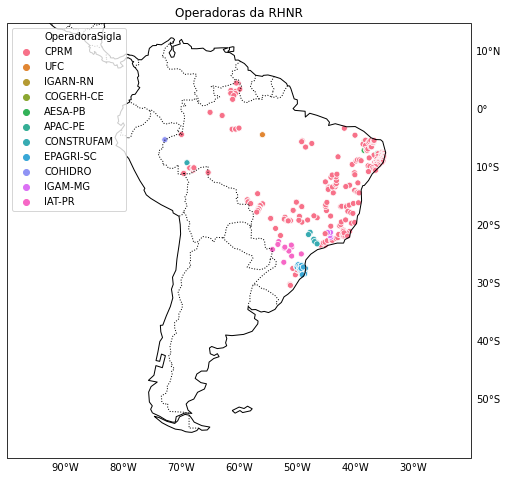

In [42]:
ScatMap(dfRHNR, 'OperadoraSigla','Operadoras da RHNR')

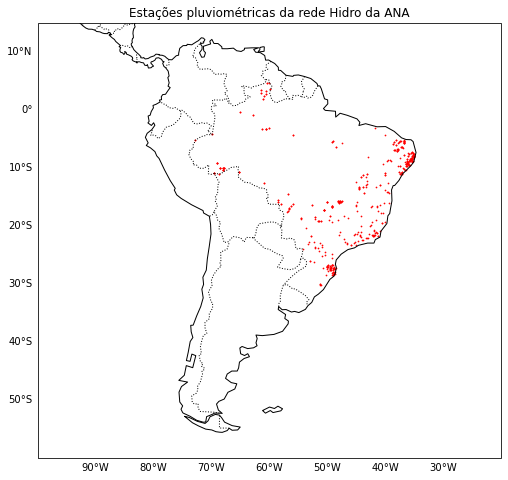

In [26]:
ScatterMap(dfHidro, 'TipoRedeEstrategica', 'Estações pluviométricas da rede Hidro da ANA', 'red')

In [27]:
sum(dfHidro['TipoEstacaoTelemetrica'])

11178